<a href="https://colab.research.google.com/github/itrail/CovidDataAnalyzing/blob/main/CovidDataAnalyzing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
from collections import OrderedDict
import json
from itertools import islice
from datetime import timedelta, date, datetime, timezone
from openpyxl import load_workbook
from bs4 import BeautifulSoup
import plotly.graph_objects as go
from numpy import mean, average
import random

In [5]:
#creating json file with excel covid19 data 

def create_json():
  covid_data = []
  #open a spreadsheet and sheet
  wb = load_workbook('covid19.xlsx')
  sheet = wb['newCases2021']

  #copy row by row with loop
  for row in islice(sheet.values, 1, sheet.max_row):
      data = OrderedDict()
      day = row[0]
      day  = day.strftime("%d.%m.%Y")
      data['date'] = day
      data['cases'] = str(row[1])
      covid_data.append(data)
  newlist = sorted(covid_data, key=lambda x: datetime.strptime(x['date'], '%d.%m.%Y'))
  j = json.dumps(newlist) 

  #save data in json file
  with open('/content/gdrive/My Drive/data.json', 'w') as f:
    f.write(j)

In [ ]:
def update_json():
  with open('/content/gdrive/My Drive/data.json', 'r') as f:
    json_object = json.load(f)
    f.close()
  #open a spreadsheet and sheet
  wb = load_workbook('covid19.xlsx')
  sheet = wb['newCases2020']

  #copy row by row with loop
  for row in islice(sheet.values, 1, sheet.max_row):
      data = OrderedDict()
      day = row[0]
      day  = day.strftime("%d.%m.%Y")
      data['date'] = day
      data['cases'] = str(row[1])
      json_object.append(data)
  newlist = sorted(json_object, key=lambda x: datetime.strptime(x['date'], '%d.%m.%Y'))
  j = json.dumps(newlist) 
  with open('/content/gdrive/My Drive/data.json', 'w') as f:
    f.write(j)

update_json()


In [ ]:
#create_json()

In [6]:
import requests

#data actualization
covid_data=[]
#url of webpage with covid data
url = 'https://www.worldometers.info/coronavirus/country/poland/'

#get the page content
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
#find lists, here's data about new cases and deaths
data_iterator = iter(soup.find_all('li', {'class': 'news_li'}))

#delta is variable to substracting date, if its before 12 data probably hasn't been updated
now = datetime.now(timezone(timedelta(hours=2)))
if now.hour >= 11:
  delta = 0
else:
  delta = 1

#getting todays date
today = date.today()
#loop for all obtained data
with open('/content/gdrive/My Drive/data.json', 'r') as f:
  json_object = json.load(f)
  f.close()
days = []
for item in json_object:
  days.append(item['date'])
iterator = 0;
while True:
    try:
      #substracting dates
      day  = today - timedelta(days=delta)
      day  = day .strftime("%d.%m.%Y")
      #getting the next row and cleaning the info
      newData = next(data_iterator).text
      newData = newData.split(" new cases and ", 1)
      newCases = newData[0]
      newDeaths= newData[1].replace(' new deaths in Poland\xa0[source]', '')
      newCases = newCases.replace(',', '')
      data = {"date": day, "cases": newCases, }

      #saving data if is not in json file
      if data['date'] not in days:
        print(data)
        json_object.append(data)
        
      print(day  + ": " + newCases)
      delta += 1
      iterator += 1
    except StopIteration:
      break

#sorting by dates
newlist = sorted(json_object, key=lambda x: datetime.strptime(x['date'], '%d.%m.%Y'))
j = json.dumps(newlist) 
with open('/content/gdrive/My Drive/data.json', 'w') as f:
    f.write(j)

09.06.2021: 428
08.06.2021: 532
07.06.2021: 195
06.06.2021: 310
05.06.2021: 415
04.06.2021: 317
03.06.2021: 572


In [ ]:
#print the data
with open('/content/gdrive/My Drive/data.json', 'r') as f:
  json_object = json.load(f)
  f.close()

cases = []
days = []
for item in json_object:
  print(item)
  cases.append(int(item['cases']))
  days.append(item['date'])


In [10]:
average = 0
for n in range(1, 8):
  i = -8 + n
  average = ((n-1)*average+ cases[i])/n
  print(str(cases[i]) + ":" + str(average))

572:572.0
317:444.5
415:434.6666666666667
310:403.5
195:361.8
532:390.1666666666667
428:395.57142857142856


In [8]:
today = date.today()
n=0
sum=0
for day in days:
  date_dt2 = datetime.strptime(day, '%d.%m.%Y')
  if date_dt2.month == today.month-1:
    n=n+1
    #print(cases[days.index(day)])
    sum=sum+cases[days.index(day)]
    
last_month_avg = sum/n
print(last_month_avg)

1470.532258064516


In [9]:
#plotting covid cases

fig = go.Figure()
fig.add_trace(go.Scatter(x=days, y=cases, name='Covid Cases', mode='markers+lines'))
fig.add_trace(go.Scatter(x=days, y=(len(json_object)+1) * [last_month_avg], name='Last month average', mode='lines'))
#fig.add_trace(go.Scatter(x=days, y=(len(json_object)+1) * [average], name='Last 7 days average', mode='lines'))
fig.add_trace(go.Scatter(x=days, y=(len(json_object)+1) * [mean(cases)], name='Todays Average', mode='lines'))
fig.update_layout(width=1300, height=500, title='Number of covid19 cases by day in 2021', xaxis_title='Days', yaxis_title='Cases')
fig.show()

In [11]:
#libraries for creating neural network
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
import plotly.graph_objects as go

In [30]:
def split_sequence(seq, n_steps):
  IN = []
  OUT = []
  for i in range(len(seq)-n_steps):
    TEMP = []
    for j in range(i,n_steps):
      TEMP.append(seq[j])
    IN.append(TEMP)
    OUT.append(seq[j+1])
    n_steps=n_steps+1
  return IN,OUT

In [149]:
#splitting the sequences of 14-days covid datasets
n = 14
X, Y = split_sequence(cases, n)

#splitting for validation data and training data

Validation_X = []
Validation_Y = []
i=0
limit = 0.2*len(X)
while(i!=limit):
    r=random.randint(1,len(X))-1
    Validation_X.append(X[r])
    Validation_Y.append(Y[r])
    del X[r], Y[r]
    i+=1

X = np.array(X)
Y = np.array(Y)
Validation_X = np.array(Validation_X)
Validation_Y = np.array(Validation_Y)
#for i in range(len(Validation_X)):
#    print(Validation_X[i], Validation_Y[i])

#print of training data set
for i in range(len(X)):
    print(X[i], Y[i])

[0 0 0 0 0 0 1 0 4 1 5 6 5 9] 20
[ 0  0  0  0  0  1  0  4  1  5  6  5  9 20] 17
[ 0  0  0  0  1  0  4  1  5  6  5  9 20 17] 36
[ 0  0  0  1  0  4  1  5  6  5  9 20 17 36] 21
[ 0  1  0  4  1  5  6  5  9 20 17 36 21 52] 61
[ 1  0  4  1  5  6  5  9 20 17 36 21 52 61] 49
[ 0  4  1  5  6  5  9 20 17 36 21 52 61 49] 68
[ 4  1  5  6  5  9 20 17 36 21 52 61 49 68] 70
[ 1  5  6  5  9 20 17 36 21 52 61 49 68 70] 111
[  5   6   5   9  20  17  36  21  52  61  49  68  70 111] 98
[  6   5   9  20  17  36  21  52  61  49  68  70 111  98] 116
[  5   9  20  17  36  21  52  61  49  68  70 111  98 116] 152
[  9  20  17  36  21  52  61  49  68  70 111  98 116 152] 150
[ 20  17  36  21  52  61  49  68  70 111  98 116 152 150] 170
[ 17  36  21  52  61  49  68  70 111  98 116 152 150 170] 168
[ 36  21  52  61  49  68  70 111  98 116 152 150 170 168] 249
[ 21  52  61  49  68  70 111  98 116 152 150 170 168 249] 224
[ 52  61  49  68  70 111  98 116 152 150 170 168 249 224] 193
[ 61  49  68  70 111  98 116 152 

In [154]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
Validation_X = Validation_X.reshape((Validation_X.shape[0], Validation_X.shape[1], n_features))
Y = Y.reshape((Y.shape[0], 1, n_features))
Validation_Y = Validation_Y.reshape((Validation_Y.shape[0], 1, n_features))
look_back = n

In [155]:
X.shape

(364, 14, 1)

In [163]:
#creating the model
from keras.models import Sequential
from keras.layers import LSTM, Dense


model = Sequential()
model.add(
    LSTM(50,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

num_epochs = 550

In [164]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [165]:
history = model.fit(X, Y, epochs=num_epochs, validation_data=(X,Y), verbose=1)

Epoch 1/550
12/12 [==============================] - 3s 64ms/step - loss: 7804.8268 - val_loss: 6656.0762
Epoch 2/550
12/12 [==============================] - 0s 11ms/step - loss: 6315.4256 - val_loss: 5221.9321
Epoch 3/550
12/12 [==============================] - 0s 11ms/step - loss: 4779.5919 - val_loss: 4610.2065
Epoch 4/550
12/12 [==============================] - 0s 11ms/step - loss: 4773.9381 - val_loss: 3953.1487
Epoch 5/550
12/12 [==============================] - 0s 11ms/step - loss: 4130.3638 - val_loss: 3911.2947
Epoch 6/550
12/12 [==============================] - 0s 10ms/step - loss: 3617.0379 - val_loss: 3578.3242
Epoch 7/550
12/12 [==============================] - 0s 12ms/step - loss: 3414.2736 - val_loss: 2772.1536
Epoch 8/550
12/12 [==============================] - 0s 11ms/step - loss: 2938.8346 - val_loss: 2489.3901
Epoch 9/550
12/12 [==============================] - 0s 11ms/step - loss: 2413.9637 - val_loss: 2348.7937
Epoch 10/550
12/12 [==========================

Text(0.5, 0, 'epoch')

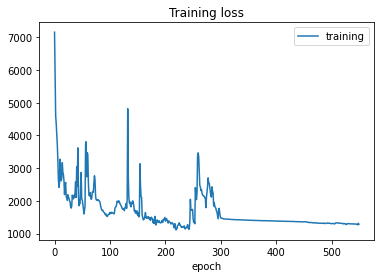

In [166]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.legend(['training'])
plt.title('Training loss')
plt.xlabel('epoch')

In [ ]:
#saving a model

model.save("covid_prediction.h5")
!cp "covid_prediction.h5" "/content/gdrive/My Drive/"

In [ ]:
#loading a model
from keras.models import load_model

model = load_model("/content/gdrive/My Drive/covid_prediction.h5")

In [ ]:
prediction = model.predict(Y)
close_test = Y.reshape((-1))
prediction = prediction.reshape((-1))

absolute_errors = np.abs(np.subtract(close_test, prediction))
relative_errors = np.divide(absolute_errors, close_test) * 100

trace2 = go.Scatter(
    x = [i for i in range (0, 199)],
    y = prediction,
    name = 'Prediction',
    mode='lines',
    line=dict(width=4, color='Green')
)
trace3 = go.Scatter(
    x = [i for i in range (0, 199)],
    y = close_test,
    mode='markers+lines',
    name = 'Test Data'
)
layout = go.Layout(
    title = "Covid Cases",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Cases"}
)
fig = go.Figure(data=[trace2, trace3], layout=layout)
fig.show()

In [ ]:
# The median of absolute errors
print("Mediana błedu bezwzględnego wynosi: " + str(np.median(absolute_errors)))
print("Najwieksza pomyłka wynosi blisko: "+ str(int(np.ceil(max(relative_errors)))) + " %")

Mediana błedu bezwzględnego wynosi: 382.484619140625
Najwieksza pomyłka wynosi blisko: 6 %


In [ ]:
np.argmax(relative_errors)

76

In [ ]:
# Relative errors [%]
np.round(relative_errors, 2)

array([5.49, 5.46, 5.37, 4.99, 5.26, 5.44, 5.44, 5.42, 5.4 , 5.22, 4.77,
       5.23, 5.43, 5.45, 5.38, 5.36, 5.24, 4.7 , 5.19, 5.43, 5.41, 5.38,
       5.37, 5.24, 4.66, 5.13, 5.44, 5.44, 5.4 , 5.42, 5.31, 4.72, 5.3 ,
       5.52, 5.54, 5.53, 5.52, 5.44, 5.11, 5.4 , 5.62, 5.62, 5.6 , 5.62,
       5.57, 5.25, 5.49, 5.67, 5.67, 5.67, 5.66, 5.64, 5.39, 5.56, 5.69,
       5.72, 5.7 , 5.72, 5.69, 5.59, 5.65, 5.74, 5.75, 5.74, 5.75, 5.72,
       5.66, 5.68, 5.76, 5.77, 5.77, 5.76, 5.76, 5.69, 5.72, 5.77, 5.77,
       5.76, 5.75, 5.73, 5.56, 5.5 , 5.66, 5.75, 5.75, 5.74, 5.72, 5.61,
       5.64, 5.72, 5.72, 5.69, 5.67, 5.62, 5.46, 5.54, 5.65, 5.63, 5.59,
       5.55, 5.45, 5.02, 5.35, 5.53, 5.51, 5.43, 5.41, 5.23, 4.71, 4.59,
       5.11, 5.4 , 5.38, 5.25, 5.1 , 4.43, 4.92, 5.12, 5.07, 4.97, 4.86,
       4.52, 3.25, 4.18, 4.62, 4.47, 4.13, 3.94, 3.16, 0.67, 2.96, 3.57,
       3.49, 2.79, 2.11, 0.85, 2.85, 0.92])

In [ ]:
#next day covid cases prediction
def predict_next_day(test_data):
  test_data = test_data.reshape((1, 14, n_features))
  return int(np.round(model.predict(test_data, verbose=1)))
next_day = predict_next_day(np.array(cases[-14:]))
print(next_day)
print("Przewidywany margines błędu: [" + str(np.round(next_day - np.median((relative_errors/100)*next_day))) + " ; " +  str(np.round(next_day + np.median((relative_errors/100)*next_day))) + "]")

1/1 [==============================] - 0s 15ms/step
502
Przewidywany margines błędu: [475.0 ; 529.0]


In [ ]:
np.median(absolute_errors)

382.484619140625

In [ ]:
#coefficient of variance
np.std(cases)/np.mean(cases) * 100 

81.83784931354369

In [ ]:
len(prediction)

137

In [ ]:
len(close_test)

137